In [1]:
import os
import cv2
import numpy as np

In [2]:
# Función para cargar las imágenes desde las carpetas
def load_images(folder_path, img_size=(128, 128)):
    data = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    data.append(img)
                    labels.append(label)
    return np.array(data), np.array(labels)

folder_path = 'mango_leaf_disease'  # Reemplaza con tu ruta
data, labels = load_images(folder_path)


Enfermedades encontradas: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


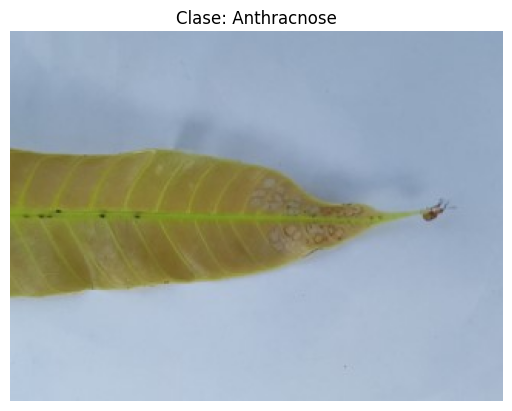

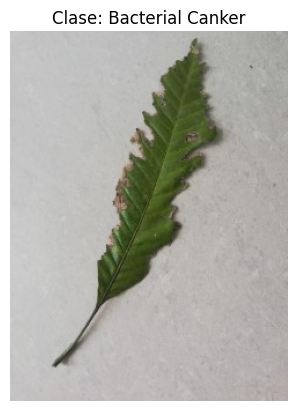

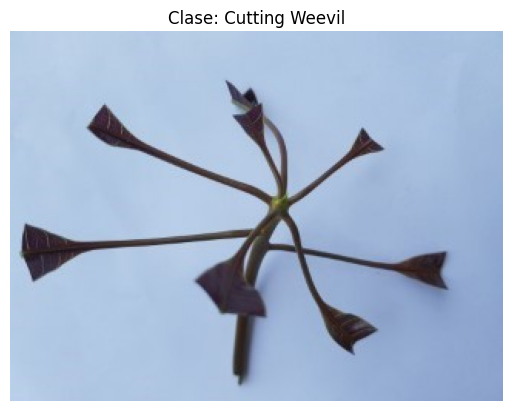

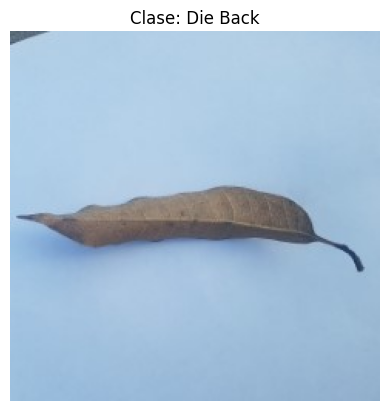

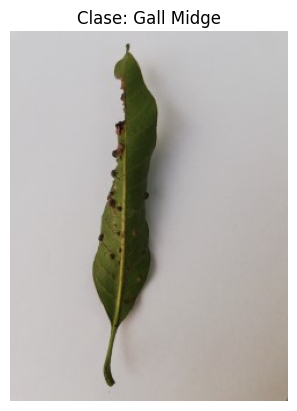

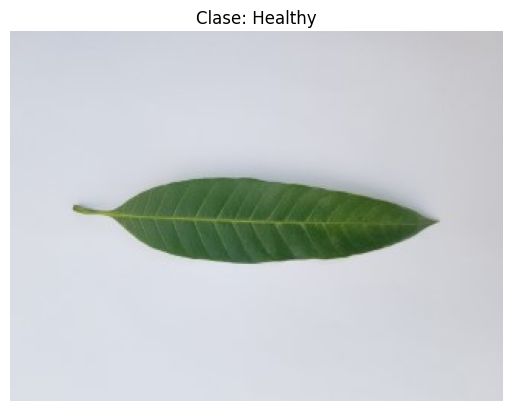

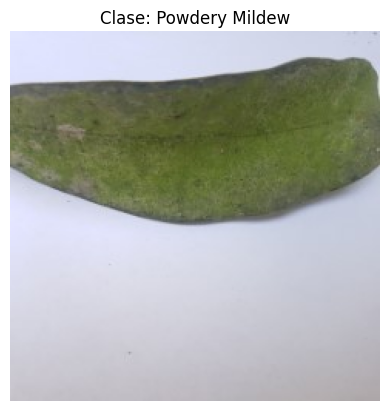

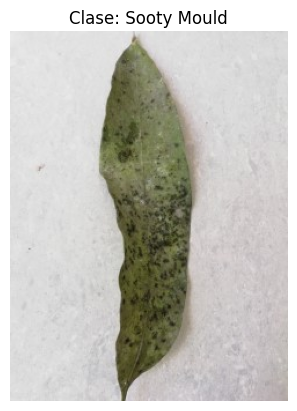

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# Ruta a la carpeta principal que contiene las subcarpetas de enfermedades
base_dir = 'mango_leaf_disease'  # Asegúrate de poner la ruta correcta a tu carpeta principal

# Listar solo las subcarpetas dentro del directorio principal, excluyendo archivos como el .txt
subcarpetas = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print(f'Enfermedades encontradas: {subcarpetas}')

# Mostrar una imagen de cada subcarpeta
for subcarpeta in subcarpetas:
    # Ruta a la subcarpeta actual (clase/enfermedad)
    subcarpeta_path = os.path.join(base_dir, subcarpeta)
    
    # Listar los archivos de imagen en la subcarpeta
    imagenes = [img for img in os.listdir(subcarpeta_path) if img.endswith(('png', 'jpg', 'jpeg'))]
    
    if imagenes:
        img_path = os.path.join(subcarpeta_path, imagenes[0])  # Tomar la primera imagen
        img = Image.open(img_path)
        
        # Mostrar la imagen con título de la clase
        plt.imshow(img)
        plt.title(f'Clase: {subcarpeta}')
        plt.axis('off')  # Ocultar ejes
        plt.show()
    else:
        print(f'No se encontraron imágenes en la subcarpeta: {subcarpeta}')


In [4]:
def color_moments(image):
    R, G, B = cv2.split(image)
    moments = []
    for channel in [R, G, B]:
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = np.mean((channel - mean) ** 3)
        moments.extend([mean, std, skewness])
    return moments


In [5]:
def fourier_descriptor(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_shift) + 1)
    return magnitude_spectrum.flatten()[:1000]  # Limitar el tamaño del descriptor


In [6]:
from sklearn.cluster import KMeans

def dominant_color_descriptor(image, k=3):
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    return kmeans.cluster_centers_.flatten()


In [7]:
def extract_features(image):
    features = []
    features.extend(color_moments(image))
    features.extend(fourier_descriptor(image))
    features.extend(dominant_color_descriptor(image))
    return features


In [8]:
from scipy.spatial.distance import euclidean

def euclidean_distance(vec1, vec2):
    return euclidean(vec1, vec2)


In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Preparar los datos
X = [extract_features(img) for img in data]
y = labels

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predecir y evaluar
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.74375


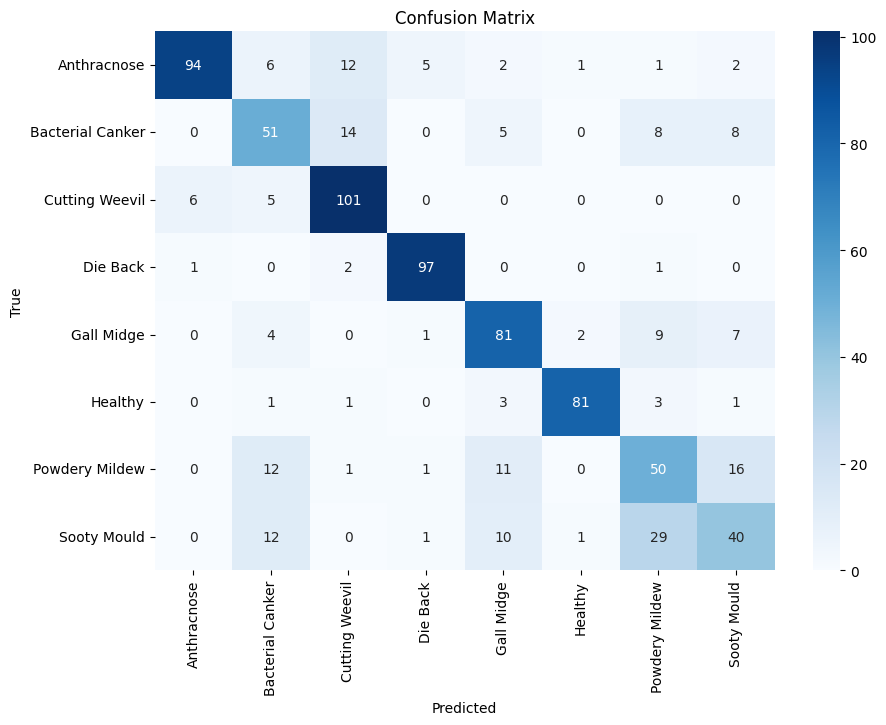

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


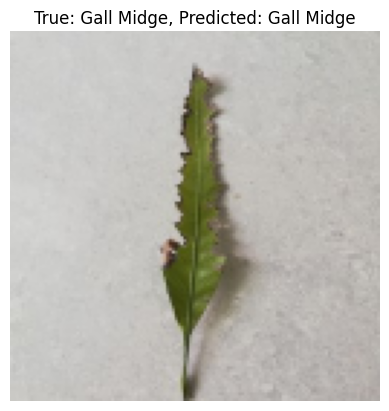

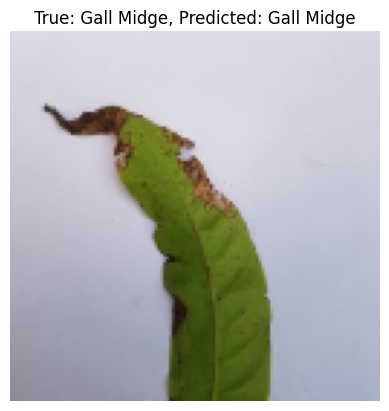

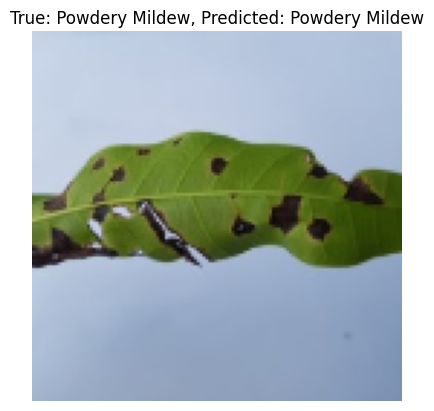

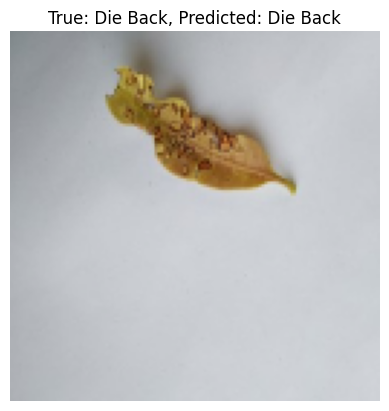

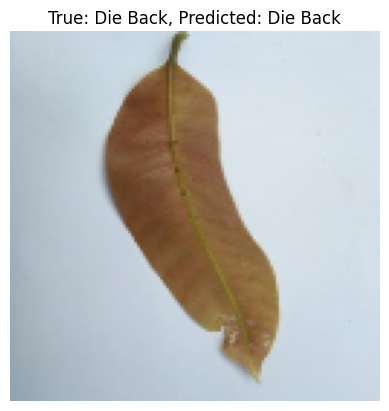

In [11]:
import random

# Seleccionar algunas imágenes aleatorias del conjunto de prueba
indices = random.sample(range(len(X_test)), 5)

for i in indices:
    img = data[i]  # Usamos la imagen original para mostrarla
    true_label = y_test[i]
    predicted_label = y_pred[i]
    
    # Mostrar la imagen con la etiqueta verdadera y predicha
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()
